## Example: Local Density of States Maximization

In this example, we will show how to compute limits on the local density of states using the dolphindes package. The LDOS is defined as 

$$
f_\textrm{LDOS}(\mathbf{p}) \equiv -\dfrac{1}{2} \Re(\mathbf{j}_i^\dagger \mathbf{e}) = -\dfrac12 \Re\left( \mathbf{j}_i^\dagger \mathbb{G}_0 \left( \dfrac{i}{\omega} \mathbf{j}_i + \mathbf{p} \right) \right) = \underbrace{-\dfrac{1}{2} \Re\left(\mathbf{e}_i^\dagger  \mathbf{j}_i \right)}_{\rho_{vac}} - \underbrace{\dfrac{1}{2} \Re\left( i\omega \mathbf{e}_i \mathbf{p} \right)}_{\rho}.
$$

This is a common way to formulate objectives for photonic limits: expand the electric field into its incident and scattered parts and use the polarization field $\mathbf{p}$ as the optimization variable. Here, we used the fact that the phase of $\mathbf{j}_i$ is irrelevant so we can take $\mathbf{j}_i$ to be real so that $\mathbf{j}_i \mathbb{G}_0 = \mathbf{e}_i$.

We will compute $\rho_0$ (LDOS in vacuum) as it is a constant. Then we will bound $\rho$. To do so, we need to define the quadratic and linear components of the objective. The quadratic component is zero, so we will pass $A_0 = 0$ to the photonics solver. For defining objectives, the optimizer will take $\mathbf{s}_0$ and add $2 \Re (\mathbf{p}^\dagger \mathbf{s}_0)$ to the objective. Thus, we define the linear term 
$$
\mathbf{s}_0 = -\frac14 i \omega \mathbf{e}_i^*.
$$

There is one additional detail. This objective is fine as is for the dense formulation. We will be using the sparse formulation, where $\mathbb{G}_0 \mathbf{p}$ is the degree of freedom instead of $\mathbf{p}$. This leverages the sparsity of $\mathbb{G}_0^{-1}$ (proportional to the sparse Maxwell operator) for faster linear algebra. Thus, we need to take all $\mathbf{p} \to \mathbb{G}_0^{-1} \mathbf{p}$. The final linear term is
$$
\mathbf{s}_0 = -\frac14 i \omega \mathbb{G}_0^{-\dagger} \mathbf{e}_i^*.
$$ There are helper methods that convert between dense and sparse objectives.

A note on optimization: in this notebook, we use BFGS with global constraints (projectors are identity matrices) and show how to utilize projector refinements to tighten limits. For fancier methods (Newton, Generalized Constraint Descent), see other tutorials. 

This example is 2D TM FDFD, but can be generalized to TE by suitable replacement of the Green's function (or in theory 3D)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sys, time, os

package_path = os.path.abspath('../../../dolphindes')
if package_path not in sys.path:
    sys.path.append(package_path)

from dolphindes import photonics

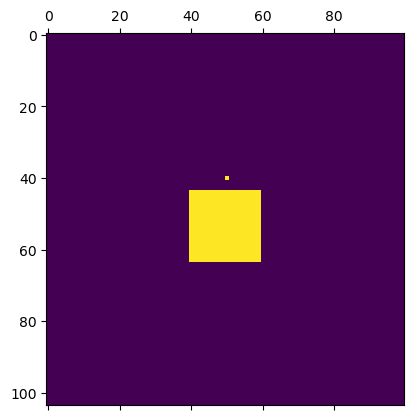

In [3]:
# First, let's define the relevant parameters for the simulation. 

wavelength = 1.0 # Dolphindes uses dimensionless units. 
omega = 2 * np.pi / wavelength
chi = 4+1e-4j # Design material 
px_per_length = 40 # pixels per length unit. If wavelength = 1.0, then this is pixels per wavelength.
dl = 1/px_per_length 
Npmlsep = int(0.5 / dl) # gap between design region and PML. Not required to be defined, it is just convenient.
Npmlx, Npmly = int(0.5 / dl), int(0.5 / dl) # PML size.
Mx, My = int(0.5 / dl), int(0.5 / dl) # design mask size 
Dx = int(0.1 / dl) # distance from the design region to the source region.
Nx, Ny = int(Npmlx*2 + Npmlsep*2 + Dx + Mx), int(Npmly*2 + Npmlsep*2 + My) # grid size. This includes the pml layer!

cx, cy = Npmlx + Npmlsep, Ny//2

ji = np.zeros((Nx, Ny), dtype=complex) # current density
ji[cx, cy] = 1.0/dl/dl # a delta function source in 2D is approximated by amplitude 1/dl/dl so that integration int(ji)dxdy = 1.0. 
design_mask = np.zeros((Nx, Ny), dtype=bool) # design mask
design_mask[Npmlx + Npmlsep + Dx: Npmlx + Npmlsep + Dx + Mx, Npmly + Npmlsep: Npmly + Npmlsep + My] = True # design mask
ndof = np.sum(design_mask) # number of degrees of freedom in the design region

chi_background = np.zeros((Nx, Ny), dtype=complex) # background material

plt.matshow(design_mask + np.real(ji)*dl*dl) # visualize where the mask and the source are

Photonics_TM_FDFD(omega=6.283185307179586, chi=(4+0.0001j), Nx=104, Ny=100, Npmlx=20, Npmly=20, dl=0.025, des_mask=True, ji=True, ei=False, chi_background=True, bloch_x=0.0, bloch_y=0.0, sparseQCQP=True)
Vacuum LDOS:  0.7878298937193576


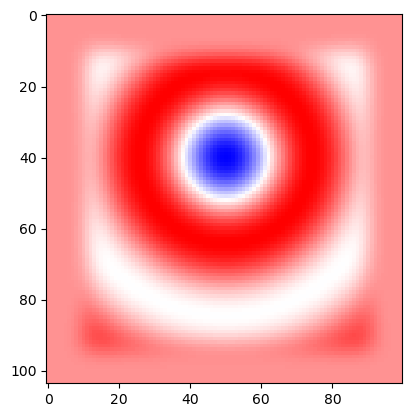

In [4]:
# Let's now initiate the photonics TM FDFD class. Leave the objective empty for now, let's use the class to compute the source field first. 
# s0 and A0 do not have to be passed now, and in general don't need to be passed to do some EM calculations. 
# note that we are specifying the sparse QCQP convention with sparseQCQP=True
ldos_problem = photonics.Photonics_TM_FDFD(omega = omega, chi = chi, grid_size = (Nx, Ny), pml_size = (Npmlx, Npmly), dl = dl,
    des_mask = design_mask, ji=ji, chi_background=chi_background, sparseQCQP=True, A0=None, s0=None, c0=0.0)

# You can print the ldos problem to see the attributes.
print(ldos_problem)

ei = ldos_problem.get_ei(ji, update=True) # update = true sets the ei to the source field. Not required if you just need to do a Maxwell solve. 
plt.imshow(np.real(ei), cmap='bwr')

vac_ldos = -np.sum(1/2 * np.real(ji.conj() * ei) * dl * dl)
print("Vacuum LDOS: ", vac_ldos)

In [5]:
# Now let's set s0. We need to restrict ei to the design region. 
ei_design = ei[ldos_problem.des_mask] # restrict the field to the design region
c0 = vac_ldos # the constant, vacuum contribution to the ldos
s0_p = - (1/4) * 1j * omega * ei_design.conj() * dl * dl
A0_p = sp.csc_array(np.zeros((ndof, ndof), dtype=complex))

# We set the objective with set_objective()
# Since A0 and c0 are specified in the dense convention (p as DOF), we set denseToSparse=True to convert to the sparse form
ldos_problem.set_objective(s0=s0_p, A0=A0_p, c0=c0, denseToSparse=True)


In [6]:
# We are ready to set up the QCQP for calculating limits. We will use Pdiags = 'global': this represents two constraints (extinction and real power global conservation). We will show how to refine these constraints below, or you may pass Pdiags = 'local' to directly do the local problem (often slower).
ldos_problem.setup_QCQP(Pdiags = 'global', verbose=1) # verbose has a few levels. 0 is silent, 1 is basic output, 2 is more verbose, 3 is very verbose.
t1 = time.time() 
result = ldos_problem.bound_QCQP('bfgs', init_lags = None, opt_params=None)
print(f'tightest bound is {result[0]}')
print(f'tightest bound on enhancement is {result[0]/vac_ldos}')
print(f'time taken: {time.time() - t1:.2f} seconds')

# Note: we get the CholmdoTypeConversionWarning because cholmod uses csc_matrix and we use csc_array (newer version of scipy). This should not be an expensive conversion.

/home/pengning/Documents/Research/DolphinDes_Dev/dolphindes/dolphindes/photonics/photonics.py:301: UserWarning: If both ji and ei are specified then ji is ignored.
  warnings.warn("If both ji and ei are specified then ji is ignored.")
/home/pengning/Documents/Research/DolphinDes_Dev/dolphindes/dolphindes/cvxopt/qcqp.py:576: CholmodTypeConversionWarning: converting matrix of class csr_array to CSC format
  self.Acho = sksparse.cholmod.analyze(A)
/home/pengning/Documents/Research/DolphinDes_Dev/dolphindes/dolphindes/cvxopt/qcqp.py:576: CholmodTypeConversionWarning: converting matrix of class csc_array to CSC format
  self.Acho = sksparse.cholmod.analyze(A)
/home/pengning/Documents/Research/DolphinDes_Dev/dolphindes/dolphindes/cvxopt/qcqp.py:621: CholmodTypeConversionWarning: converting matrix of class csr_array to CSC format
  tmp = self.Acho.cholesky(A)
/home/pengning/Documents/Research/DolphinDes_Dev/dolphindes/dolphindes/cvxopt/qcqp.py:587: CholmodTypeConversionWarning: converting mat

Precomputed 2 A matrices for the projectors.
Found feasible point for dual problem: [4.75398045e-07 1.00000000e-01] with dualvalue 1182.1679096925432
tightest bound is 1.9906008734195448
tightest bound on enhancement is 2.526688678975973
time taken: 0.61 seconds


In [7]:
# We may also use Newton's method. This will often converge faster but may require more memory, and it tends to be faster for intermediate # of constraints (too many makes the Hessian too large, too few and BFGS is fast enough). 
# We recommend either using Newton or finding the optimum of the QCQP with Newton at low tolerance or for low number of parameters, then using iterative splitting or higher tolerance with BFGS. 

t1 = time.time()
result_newton = ldos_problem.bound_QCQP('newton', init_lags = None, opt_params=None)
print(f'tightest bound is {result_newton[0]}')
print(f'tightest bound on enhancement is {result_newton[0]/vac_ldos}')
print(f'time taken: {time.time() - t1:.2f} seconds')


tightest bound is 1.9906008734192966
tightest bound on enhancement is 2.526688678975658
time taken: 0.41 seconds


### Iterative Splitting
Iterative splitting is a way to add constraints to the bounds problem without changing the dual value. For example, if we have projector $P=[1,1]$ with multiplier $\lambda = 1$, we can split it into two projectors $P_1 = [1,0]$ and $P_2 = [0,1]$ with multipliers $\lambda_1 = 1$ and $\lambda_2 = 1$. The dual value remains the same, but now both multipliers may be optimized independently, tightening the bounds. This is 

Iterative splitting consists of two steps: the projector refinement, and the new optimization. We do this in a loop to successively tighten the bounds.

In [8]:
results = [] 
result_counter = 0
# This problem is small enough that we can just use Newton for all the iterative splitting steps
for result in ldos_problem.QCQP.iterative_splitting_step(method='newton'): # When we reach pixel level constraints, the generator will return and stop this loop.
    result_counter += 1
    num_constr = ldos_problem.QCQP.get_number_constraints()
    print(f'at step {result_counter}, number of constraints is {num_constr}, bound is {result[0]}')

    results.append((num_constr, result[0]))
    # Perform saving, break condition, etc.

    if result_counter > 0:
        assert results[result_counter-1][1] >= result[0], "Iterative splitting step must decrease dualval."


Splitting projectors: 2 → 4
Precomputed 6 A matrices for the projectors.
previous dual: 1.9906008734192966, new dual: 1.9906008734203118 (should be the same)
at step 1, number of constraints is 6, bound is 1.9551398988478126
Splitting projectors: 6 → 10
Precomputed 10 A matrices for the projectors.
previous dual: 1.9551398988478126, new dual: 1.9551398988387003 (should be the same)
at step 2, number of constraints is 10, bound is 1.8715794692672758
Splitting projectors: 10 → 18
Precomputed 18 A matrices for the projectors.
previous dual: 1.8715794692672758, new dual: 1.8715794692682644 (should be the same)
at step 3, number of constraints is 18, bound is 1.860621337988173
Splitting projectors: 18 → 34
Precomputed 34 A matrices for the projectors.
previous dual: 1.860621337988173, new dual: 1.8564551978233395 (should be the same)
at step 4, number of constraints is 34, bound is 1.834665345879893
Splitting projectors: 34 → 66
Precomputed 66 A matrices for the projectors.
previous dual: 1

In [9]:
# The code above might take a while to run, because going all the way to pixel level constraints can be expensive.
# See the tutorial in LDOS_gcd.ipynb on how to make this process using general constraint descent. 
# If you want to stop the iterative splitting step early, you can do so by setting a break condition on num_constr. 
# Let's see the results.
print(results)

[(6, np.float64(1.9551398988478126)), (10, np.float64(1.8715794692672758)), (18, np.float64(1.860621337988173)), (34, np.float64(1.834665345879893)), (66, np.float64(1.756463600317182)), (130, np.float64(1.6117768599457407)), (258, np.float64(1.563433148887993)), (512, np.float64(1.5492452129903385)), (800, np.float64(1.5399515109519881))]


## Advanced Usage: Lazy Initialization 
The photonics solver allows lazy initialization. We do not recommend this, since it leaves room for error (for example, if you change chi_background, you should re-compute Ginv in the sparse problem). If you are an advanced user and need to use this functionality, here is how to do it:
1. Initialize the problem 
2. Run setup_FDFD() to set up the finite difference frequency domain problem. 
3. Run setup_EM_operators() to set up the operators needed to do limits calculations. 

Steps 2 and 3 are done automatically if all parameters needed are present on initialization. If you want to use this method, you should probably familiarize yourself with dolphindes/photonics/photonics.py.

In [10]:
ldos_problem_lazy = photonics.Photonics_TM_FDFD(omega = omega) 
# If we try to setup_EM_solver(), we will get an error:
try:
    ldos_problem_lazy.setup_EM_solver()
except AttributeError as e:
    print(e)


Nx, Ny, Npmlx, Npmly, dl undefined.


/home/pengning/Documents/Research/DolphinDes_Dev/dolphindes/dolphindes/photonics/photonics.py:131: UserWarning: Photonics_TM_FDFD initialized with missing attributes (lazy initialization). We strongly recommend passing all arguments for expected behavior.
  warnings.warn("Photonics_TM_FDFD initialized with missing attributes (lazy initialization). We strongly recommend passing all arguments for expected behavior.")


In [11]:
# We may elect to initialize the relevant EM solver by passing them into setup_EM_solver():
ldos_problem_lazy.setup_EM_solver(omega=omega*0.5, Nx=Nx, Ny=Ny, Npmlx=Npmlx, Npmly=Npmly, dl=dl, bloch_x=0, bloch_y=0)
print(ldos_problem_lazy.omega) # omega is now set

3.141592653589793


In [12]:
# Or, we could directly re-define the attributes of the class. 
# Be careful! If you change the attributes, you must call setup_FDFD() and setup_EM_operators() again. 

ldos_problem_lazy.omega = omega # change the frequency back to omega
print(ldos_problem_lazy)

Photonics_TM_FDFD(omega=6.283185307179586, chi=None, Nx=104, Ny=100, Npmlx=20, Npmly=20, dl=0.025, des_mask=False, ji=False, ei=False, chi_background=False, bloch_x=0, bloch_y=0, sparseQCQP=True)


In [13]:
ldos_problem_lazy.setup_EM_solver() # re-setup the EM operators, if you pass nothing it will use the existing attributes.

In [14]:
# If the problem doesn't have des_mask, setup_EM_operators will raise an error.
try:
    ldos_problem_lazy.setup_EM_operators() # setup the EM operators
except AttributeError as e:
    print(e)

des_mask undefined.


In [15]:
ldos_problem_lazy.des_mask = design_mask # set the design mask
ldos_problem_lazy.setup_EM_operators() # now it works, since we have des_mask set.

In [16]:
# Similarly, if you don't set the objectives, setup_QCQP will fail. We can do this with set_objective() (as above) or directly:
ldos_problem_lazy.s0 = ldos_problem_lazy.Ginv.T.conj() @ s0_p # set the source field in sparse form convention
ldos_problem_lazy.A0 = ldos_problem_lazy.Ginv.T.conj() @ A0_p @ ldos_problem_lazy.Ginv # set the A0 matrix in sparse form convention
ldos_problem_lazy.c0 = vac_ldos # set the c0 value

# And we set ei. 
ei = ldos_problem_lazy.get_ei(ji, update=True) # update the ei field to the source field.
# alternatively we could just set it, since we already know it from before. 
# ldos_problem_lazy.ei = ei
# or 
# ldos_problem_lazy.set_ei(ei)

# And we set chi 
ldos_problem_lazy.chi = chi # set the design material

In [17]:
# The rest is the same as before. 
ldos_problem_lazy.setup_QCQP(Pdiags = 'global', verbose=1) # verbose has a few levels. 0 is silent, 1 is basic output, 2 is more verbose, 3 is very verbose.
result = ldos_problem_lazy.bound_QCQP('bfgs', init_lags = None, opt_params=None)
print(f'tightest bound is {result[0]}')
print(f'tightest bound on enhancement is {result[0]/vac_ldos}')

Precomputed 2 A matrices for the projectors.
Found feasible point for dual problem: [7.41730006e-07 1.00000000e-01] with dualvalue 1124.1218406952066
tightest bound is 1.9906008734194964
tightest bound on enhancement is 2.5266886789759115


## Dense vs Sparse
The photonics solver supports both dense and sparse formulations. The dense formulation uses the polarization vector $\mathbf{p}$ as the optimization variable, while the sparse formulation uses $\mathbb{G}_0 \mathbf{p}$ as the optimization variable. The sparse formulation is more efficient, especially for large numbers of constraints. However, in cases where the objective is dense (for example focusing objectives, where the objective has off-diagonal components of the Green's function that cannot be necessarily inverted), the dense formulation is currently the only option. New QCQP formulations that allow for sparse representations of such problems is currently under development.

If sparseQCQP=True, the objective parameters A0 and s0 should be specified with $\mathbb{G}_0 \mathbf{p}$ as optimization variable.
If sparseQCQP=False, the objective parameters A0 and s0 should be specified with $\mathbf{p}$ as optimization variable.
The set_objective() method with denseToSparse=True can be used to take input A0 and s0 for $\mathbf{p}$ and assign to the Photonic_FDFD object
A0 and s0 for $\mathbb{G}_0 \mathbf{p}$. 

 For now, the dense form doesn't support iterative splitting. 

In [18]:
ldos_problem_dense = photonics.Photonics_TM_FDFD(omega = omega, chi = chi, grid_size = (Nx, Ny), pml_size = (Npmlx, Npmly), dl = dl,
    des_mask = design_mask, ji=ji, chi_background=chi_background, sparseQCQP=False, A0=None, s0=None, c0=0.0) # only difference is sparseQCQP=False, which means we will use dense matrices for the QCQP.

# You can print the ldos problem to see the attributes.
print(ldos_problem_dense)

ei = ldos_problem_dense.get_ei(ji, update=True) # update = true sets the ei to the source field. Not required if you just need to do a Maxwell solve. 
vac_ldos = -np.sum(1/2 * np.real(ji.conj() * ei) * dl * dl)
print("Vacuum LDOS: ", vac_ldos)

ldos_problem_dense.set_objective(s0=s0_p, A0=A0_p, c0=vac_ldos) # we use default denseToSparse=False since this is a dense QCQP formulation

ldos_problem_dense.setup_QCQP(Pdiags = 'global', verbose=1) # verbose has a few levels. 0 is silent, 1 is basic output, 2 is more verbose, 3 is very verbose.
t1 = time.time()
result = ldos_problem_dense.bound_QCQP('bfgs', init_lags = None, opt_params=None)
print(f'tightest bound is {result[0]}')
print(f'tightest bound on enhancement is {result[0]/vac_ldos}')
print(f'time taken: {time.time() - t1:.2f} seconds')


Photonics_TM_FDFD(omega=6.283185307179586, chi=(4+0.0001j), Nx=104, Ny=100, Npmlx=20, Npmly=20, dl=0.025, des_mask=True, ji=True, ei=False, chi_background=True, bloch_x=0.0, bloch_y=0.0, sparseQCQP=False)
Vacuum LDOS:  0.7878298937193576
Precomputed 2 A matrices for the projectors.
Found feasible point for dual problem: [7.55050691e-07 1.00000000e-01] with dualvalue 1121.4097397839025
tightest bound is 1.9905938957918767
tightest bound on enhancement is 2.526679822206607
time taken: 1.02 seconds


In [19]:
t1 = time.time()
result_newton = ldos_problem_dense.bound_QCQP('newton', init_lags = None, opt_params=None)
print(f'tightest bound is {result_newton[0]}')
print(f'tightest bound on enhancement is {result_newton[0]/vac_ldos}')
print(f'time taken: {time.time() - t1:.2f} seconds')

tightest bound is 1.9905938957918767
tightest bound on enhancement is 2.526679822206607
time taken: 0.98 seconds
